In [1]:
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
from matplotlib import cm
from keras.datasets.cifar10 import load_data

import random
import numpy as np

In [2]:
def DataLoad(subset=None):
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  
  if subset is not None:
    train_length = int(len(x_train) * subset)
    x_train = x_train[:train_length]
    y_train = y_train[:train_length]
    
    test_length = int(len(x_test) * subset)
    x_test = x_test[:test_length]
    y_test = y_test[:test_length]
  
  val_split = 0.2
  val_length = int(len(x_train) * val_split)
  x_val = x_train[:val_length]
  y_val = y_train[:val_length]
  
  x_train = x_train[val_length:]
  y_train = y_train[val_length:]
  
  return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = DataLoad()

In [3]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((40000, 32, 32, 3),
 (40000, 1),
 (10000, 32, 32, 3),
 (10000, 1),
 (10000, 32, 32, 3),
 (10000, 1))

In [4]:
# Labels
lables = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

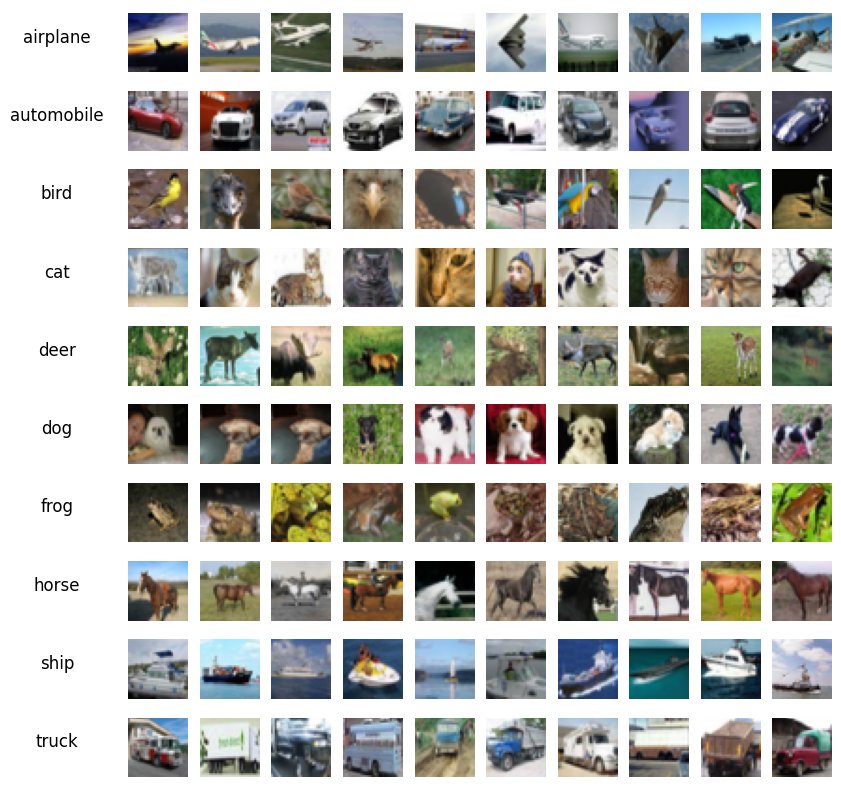

In [5]:
# Plot the 10 images from each label
fig, axes = plt.subplots(10, 11, figsize=(10, 10))

for i in range(10):
    axes[i, 0].text(0, 0.5, lables[i], fontsize=12, ha='center')
    axes[i, 0].axis('off')
    for j in range(1, 11):  
        index = random.choice(np.where(y_train == i)[0])
        axes[i, j].imshow(x_train[index])
        axes[i, j].axis('off')

# Conditional Variational Autoencoders


## Setup


In [7]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import layers

## Sampling Layer


In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder


In [124]:
latent_dim = 2
input_shape = (32, 32, 3)

# Define inputs for images and labels
encoder_inputs = [keras.Input(shape=input_shape), keras.Input(shape=(1,))]

# Process image input
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs[0])
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)

# Create label embedding
num_labels = 10  # Adjust based on your data
label_embedding = layers.Embedding(num_labels, latent_dim)(encoder_inputs[1])

# Concatenate image features and label embedding
x = layers.concatenate([x, label_embedding])

# Output mean and log variance for latent space
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])  # Reparameterization trick

# Create the encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


## Decoder


In [89]:
latent_inputs = keras.Input(shape=(latent_dim,))

output_shape = (32, 32, 3)

x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 32, 32, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,547 (267.76 KB)

 Trainable params: 68,547 (267.76 KB)

 Non-trainable params: 0 (0.00 B)

## VAE Model


In [116]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Train


In [117]:
train_dataset = x_train
train_dataset = train_dataset.astype("float32") / 255
train_labels = y_train

test_dataset = np.concatenate([x_val, x_test])
test_dataset = test_dataset.astype("float32") / 255
test_labels = np.concatenate([y_val, y_test])

In [118]:
vae = VAE(encoder, decoder)

def vae_loss(data, reconstruction):
    z_mean, z_log_var, z = encoder(data)
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.binary_crossentropy(data, reconstruction),
            axis=(1, 2),
        )
    )
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    total_loss = reconstruction_loss + kl_loss
    
    return total_loss

# Compile the VAE model using the custom loss function
vae.compile(optimizer=keras.optimizers.Adam(), loss=vae_loss)

In [123]:
vae.fit([train_dataset, train_labels], epochs=2, batch_size=128, validation_data=([test_dataset, test_labels]))


Epoch 1/2


ValueError: Exception encountered when calling Concatenate.call().

[1mShape must be rank 2 but is rank 3 for '{{node encoder_1/concatenate_1_1/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](encoder_1/dense_5_1/Relu, encoder_1/embedding_2_1/GatherV2, encoder_1/concatenate_1_1/concat/axis)' with input shapes: [?,16], [?,1,2], [].[0m

Arguments received by Concatenate.call():
  • inputs=['tf.Tensor(shape=(None, 16), dtype=float32)', 'tf.Tensor(shape=(None, 1, 2), dtype=float32)']

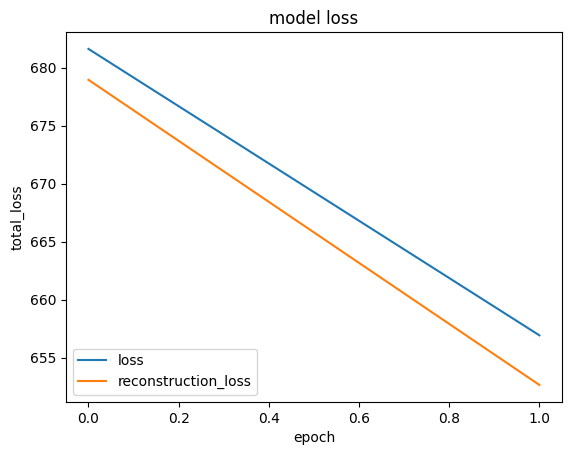

In [16]:
# plot the loss
plt.plot(history.history["loss"])
plt.plot(history.history["reconstruction_loss"])
# plt.plot(history.history["kl_loss"])
plt.title("model loss")
plt.ylabel("total_loss")
plt.xlabel("epoch")
plt.legend(["loss", "reconstruction_loss", "kl_loss"], loc="lower left")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


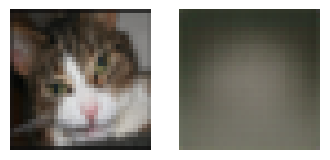

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


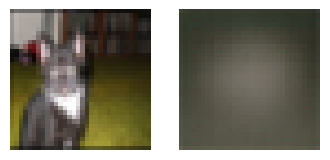

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


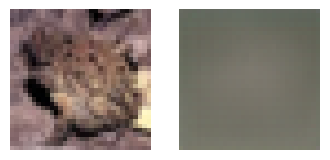

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


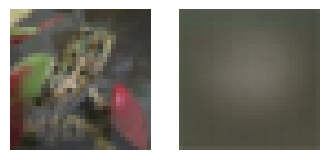

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


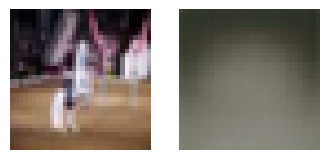

In [20]:
# Generate images
random_5 = np.random.randint(0, len(train_dataset), 5)
sample_5 = []
generated_5 = []
for i in random_5:
    image = train_dataset[i]
    sample_5.append(image)
    image = np.expand_dims(image, axis=0)
    z_mean, _, _ = encoder.predict(image)
    samples = decoder.predict(z_mean)
    sample = samples[0]
    generated_5.append(sample)
    
    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    axes[0].imshow(image[0])
    axes[0].axis('off')
    axes[1].imshow(sample)
    axes[1].axis('off')
    plt.show()


## Evaluations

In [24]:
# Get quality of Generations

def log_likelihood_loss(y_true, y_pred): # define the negative log likelihood loss
  
  # Flatten the true and predicted pixel values
  y_true_flat = tf.reshape(y_true, shape=(-1,))
  #TypeError: Cannot convert 1.0 to EagerTensor of dtype uint8
  y_pred_flat = tf.clip_by_value(y_pred, clip_value_min=1e-7, clip_value_max=1.0)
  y_pred_flat = tf.reshape(y_pred_flat, shape=(-1,))

  # Compute the negative log likelihood
  neg_log_likelihood = -tf.reduce_mean(tf.math.log(y_pred_flat) * y_true_flat)

  return neg_log_likelihood

# frechet inception distance
from scipy import linalg
def calculateFID(y_true,y_pred, input_shape): # define the FID metric
    model = keras.applications.MobileNetV2(include_top=False, pooling='avg', input_shape=input_shape,weights='imagenet') # load the pre-trained model
    
    real = keras.applications.mobilenet_v2.preprocess_input(y_true) # preprocess the real and generated images
    generated = keras.applications.mobilenet_v2.preprocess_input(y_pred)
    
    real = model.predict(real)  # get the features from the pre-trained model
    generated = model.predict(generated)
    
    mu,sigma = np.mean(real, axis=0), np.cov(real, rowvar=False) # calculate the mean and covariance of the real and generated images
    mu2, sigma2 = np.mean(generated, axis=0), np.cov(generated, rowvar=False)
    
    mu_difference = mu - mu2
    sigma_epsilon = linalg.sqrtm(sigma.dot(sigma2)).real
    
    fid = np.real(mu_difference.dot(mu_difference) + np.trace(sigma + sigma2 - 2 * sigma_epsilon)) # calculate the FID
    
    return fid

In [22]:
_sample_5 = np.array(sample_5)
_generated_5 = np.array(generated_5)

_sample_5.shape, _generated_5.shape

((5, 32, 32, 3), (5, 32, 32, 3))

In [25]:
num_pairs = min(len(_sample_5), len(_generated_5))

# convert real samples to float32
_real_samples = _sample_5.astype(np.float32)
# convert fake samples to float32
__generated_5 = _generated_5.astype(np.float32)


# calculate the log likelihood loss
loglikelihood_1 = log_likelihood_loss(_real_samples, __generated_5)

# calculate the FID
fid_1 = calculateFID(_real_samples, __generated_5, (32, 32, 3))

print(f"Log Likelihood Loss:")
print(f"VAE: {loglikelihood_1}")

print(f"FID :")
print(f"VAE: {fid_1}")
print("\n")

C:\Users\faraz\AppData\Local\Temp\ipykernel_15016\3701101615.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = keras.applications.MobileNetV2(include_top=False, pooling='avg', input_shape=input_shape,weights='imagenet') # load the pre-trained model


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Log Likelihood Loss:
VAE: 0.3621455430984497
FID :
VAE: 0.10799036713986598


